Epoch[1/25], G Loss: 12.2709, D Loss: -9.5116


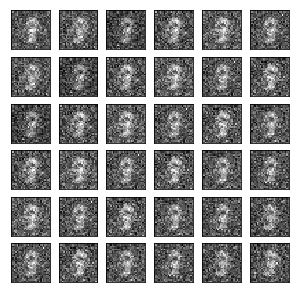

Epoch[2/25], G Loss: 7.6088, D Loss: -6.5584


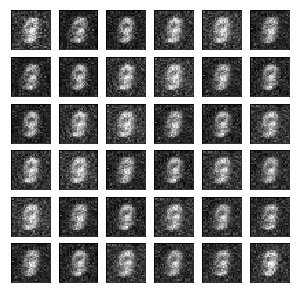

Epoch[3/25], G Loss: 3.1787, D Loss: -4.4102


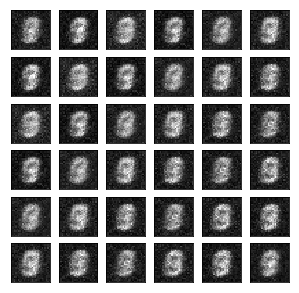

Epoch[4/25], G Loss: 1.0168, D Loss: -4.0260


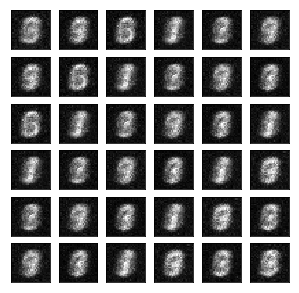

Epoch[5/25], G Loss: 0.0645, D Loss: -3.8643


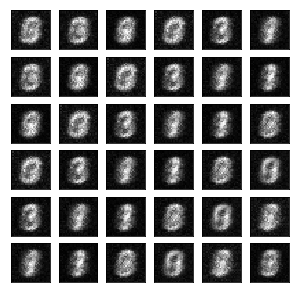

Epoch[6/25], G Loss: -0.3957, D Loss: -3.6011


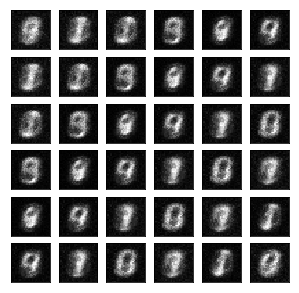

Epoch[7/25], G Loss: -0.7147, D Loss: -3.4522


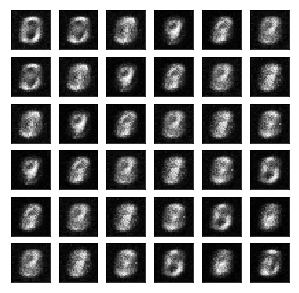

Epoch[8/25], G Loss: -0.9308, D Loss: -3.3404


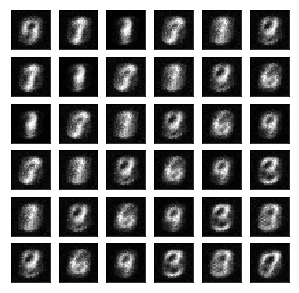

Epoch[9/25], G Loss: -1.0231, D Loss: -3.2236


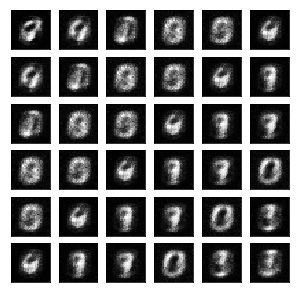

Epoch[10/25], G Loss: -1.0768, D Loss: -3.1053


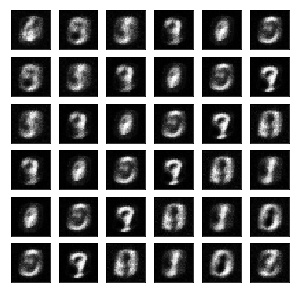

Epoch[11/25], G Loss: -1.1527, D Loss: -2.9671


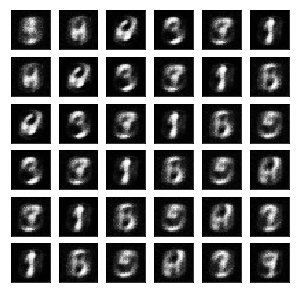

Epoch[12/25], G Loss: -1.1877, D Loss: -2.8079


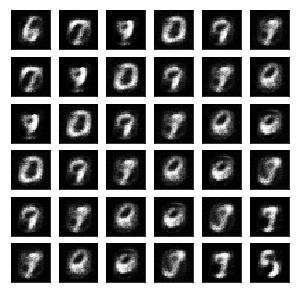

Epoch[13/25], G Loss: -1.2052, D Loss: -2.6581


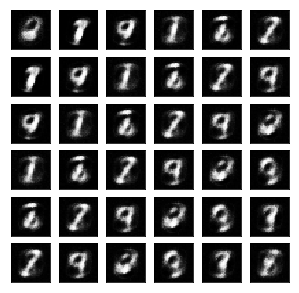

Epoch[14/25], G Loss: -1.2440, D Loss: -2.5190


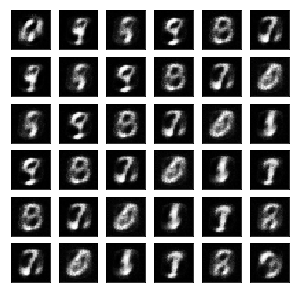

Epoch[15/25], G Loss: -1.2958, D Loss: -2.4105


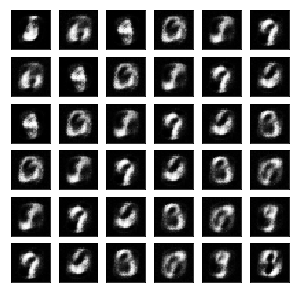

Epoch[16/25], G Loss: -1.2864, D Loss: -2.3010


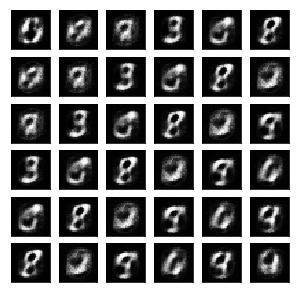

Epoch[17/25], G Loss: -1.3309, D Loss: -2.2086


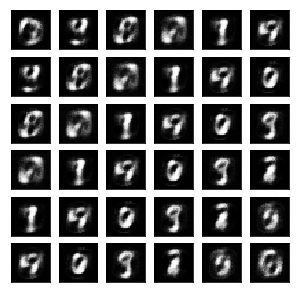

Epoch[18/25], G Loss: -1.3901, D Loss: -2.1284


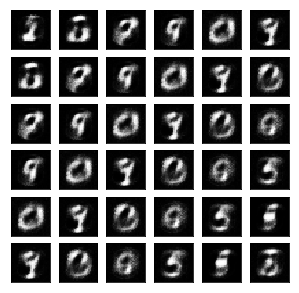

Epoch[19/25], G Loss: -1.4137, D Loss: -2.0521


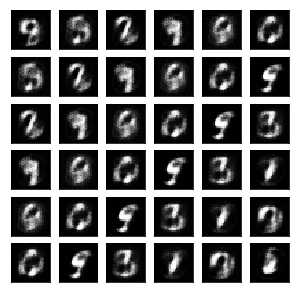

Epoch[20/25], G Loss: -1.4323, D Loss: -1.9766


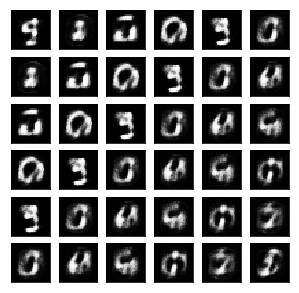

Epoch[21/25], G Loss: -1.4456, D Loss: -1.9017


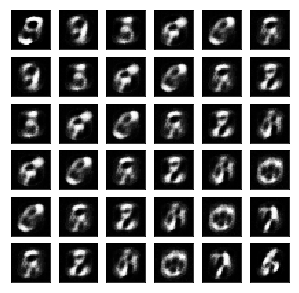

Epoch[22/25], G Loss: -1.4670, D Loss: -1.8499


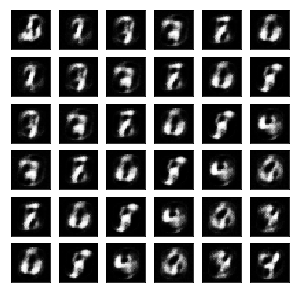

Epoch[23/25], G Loss: -1.4435, D Loss: -1.8057


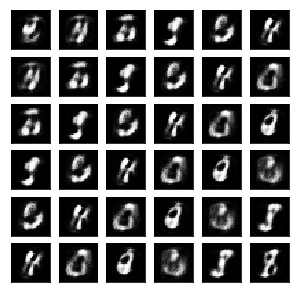

Epoch[24/25], G Loss: -1.3957, D Loss: -1.7655


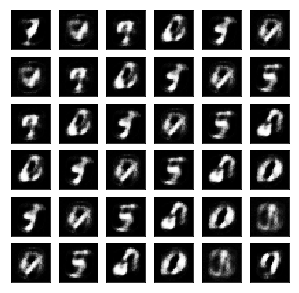

Epoch[25/25], G Loss: -1.3651, D Loss: -1.7282


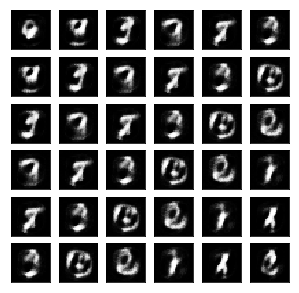

In [1]:
""" (WGANGP)
Wasserstein GAN with Gradient Penalties ('improved methods for WGAN training')

https://arxiv.org/pdf/1704.00028.pdf

The output of WGANGP's D is unbounded unless passed through an activation function. In this implementation,
we include a sigmoid activation function as this empirically improves visualizations for binary MNIST.

WGAN GP roposes a gradient penalty to add to the WGAN discriminator loss as an alternative method for enforcing 
the Lipschitz constraint (previously done via weight clipping). This penalty does not suffer from the biasing
of the discriminator toward simple funtions due to weight clipping. Additionally, the reformulation of the 
discriminator by adding a gradient penaltyterm makes batch normalization not necessary. This is notable because 
batch normalization implicitly changes the discriminator's problem from mapping one-to-one to many-to-many.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is the approximate least-squares distance between z~P(G(z)) and real.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination


class WGANGP(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class WGANGPTrainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []
        
        self.viz = viz

    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=5):
        """ Train a WGAN GP
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the Wasserstein distance between real, generated
                    # distributions                    
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            self.generate_images(epoch)
            
            if self.viz:
                plt.show()       
                        
    def train_D(self, images, LAMBDA=10):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: Wasserstein loss for discriminator, 
            -E[D(x)] + E[D(G(z))] + λE[(||∇ D(εx + (1 − εG(z)))|| - 1)^2]
        """   
        
        # ORIGINAL CRITIC STEPS:
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = self.model.D(images) # D(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # GRADIENT PENALTY:
        # Uniformly sample along one straight line per each batch entry. 
        epsilon = to_cuda(torch.rand(images.shape[0], 1).expand(images.size()))

        # Generate images from the noise, ensure unit gradient norm 1
        # See Section 4 and Algorithm 1 of original paper for full explanation.
        G_interpolation = epsilon*images + (1-epsilon)*G_output # negation doesn't matter; we square later on
        D_interpolation = self.model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        weight = to_cuda(torch.ones(D_interpolation.size()))
            
        gradients = torch.autograd.grad(outputs=D_interpolation, 
                                        inputs=G_interpolation,
                                        grad_outputs=weight,
                                        only_inputs=True,
                                        create_graph=True,
                                        retain_graph=True)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim = 1) - 1) **2)
        
        # Compute WGAN-GP loss for D
        D_loss = torch.mean(DG_score) - torch.mean(DX_score) + grad_penalty
        
        return D_loss
    
    def train_G(self, images):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: wasserstein loss for generator, 
            -E[D(G(z))]
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute WGAN-GP loss for G (same loss as WGAN)
        G_loss = -1 * (torch.mean(DG_score))
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        plt.plot(self.Dlosses, 'r')
        plt.plot(self.Glosses, 'g')
        
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = WGANGP(image_size=784, 
              hidden_dim=256, 
              z_dim=128)

trainer = WGANGPTrainer(model=model, 
                        train_iter=train_iter, 
                        val_iter=val_iter, 
                        test_iter=test_iter,
                        viz=True)

trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=5)